In [1]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,
    r2_score,
)
import numpy as np

In [2]:
def create_model(df, x_cols, y_col):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = xgb.XGBClassifier(eval_metric="mlogloss")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    display(cm)
    return model


def create_reg_model(df, x_cols, y_col):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = xgb.XGBRegressor(
        objective="reg:squarederror", n_estimators=100, colsample_bytree=0.5
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    residuals = y_test - y_pred

    return model

In [3]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp["year"] = pbp["game_id"].apply(lambda x: int(x.split("_")[0]))
small = pbp.loc[pbp.year > 2021].dropna(how="all", axis=1)
print(pbp.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards',
       'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type',
       'defense_coverage_type', 'year'],
      dtype='object', length=393)


In [4]:
desc_cols = [
    "play_id",
    "game_id",
    "home_team",
    "away_team",
    "game_half",
    "posteam",
    "side_of_field",
    "desc",
]

In [5]:
play_type_mapping = {
    "field_goal": 0,
    "no_play": 1,
    "pass": 2,
    "punt": 3,
    "qb_kneel": 4,
    "qb_spike": 5,
    "run": 6,
    np.nan: 7,
}

In [6]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    # "yards_gained",
    "posteam_score",
    # "total_away_score",
    "score_differential",
    "quarter_seconds_remaining",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "wind",
    "temp",
    "spread_line",
    "total_line",
]

pbp["play_type_enc"] = pbp["play_type"].map(play_type_mapping)
y_col = "play_type_enc"
data = pbp.loc[
    (~pbp.down.isna()) & (~pbp.rush_attempt.isna()) & ~(pbp.play_type.isna())
][game_context_cols + [y_col]]

In [7]:
team_receiver_stats = pd.read_csv("data/team_receiver_stats.csv", index_col=0)
receiver_cols = ([x for x in team_receiver_stats.columns if 'ception' in x] + 
[x for x in team_receiver_stats.columns if 'arget' in x]
)

In [ ]:
team_rb_cols = 'carries_roll_RB_1', 'carries_roll_RB_2',
       'carries_roll_RB_0', 'rushing_yards_roll_RB_1',
       'rushing_yards_roll_RB_2', 'rushing_yards_roll_RB_0',
       'rushing_tds_roll_RB_1', 'rushing_tds_roll_RB_2',
       'rushing_tds_roll_RB_0', 'rushing_first_downs_roll_RB_1',
       'rushing_first_downs_roll_RB_2', 'rushing_first_downs_roll_RB_0',
       'receptions_roll_RB_1', 'receptions_roll_RB_2', 'receptions_roll_RB_0',
       'targets_roll_RB_1', 'targets_roll_RB_2', 'targets_roll_RB_0',
       'receiving_yards_roll_RB_1', 'receiving_yards_roll_RB_2',
       'receiving_yards_roll_RB_0', 'receiving_tds_roll_RB_1',
       'receiving_tds_roll_RB_2', 'receiving_tds_roll_RB_0',
       'fantasy_points_roll_RB_1', 'fantasy_points_roll_RB_2',
       'fantasy_points_roll_RB_0', 'fantasy_points_ppr_roll_RB_1',
       'fantasy_points_ppr_roll_RB_2', 'fantasy_points_ppr_roll_RB_0']
rusher_stats = ["ppr_roll", "rush_roll"]

In [8]:
def get_rusher_number(row):
    for i in range(3):
        if row[f"gsis_id_RB_{i}"] == row["rusher_id"]:
            return i
    return None



In [16]:
team_rb_stats.columns

Index(['team_name', 'season', 'week', 'game_type', 'gsis_id_RB_1',
       'gsis_id_RB_2', 'gsis_id_RB_0', 'full_name_RB_1', 'full_name_RB_2',
       'full_name_RB_0', 'carries_roll_RB_1', 'carries_roll_RB_2',
       'carries_roll_RB_0', 'rushing_yards_roll_RB_1',
       'rushing_yards_roll_RB_2', 'rushing_yards_roll_RB_0',
       'rushing_tds_roll_RB_1', 'rushing_tds_roll_RB_2',
       'rushing_tds_roll_RB_0', 'rushing_first_downs_roll_RB_1',
       'rushing_first_downs_roll_RB_2', 'rushing_first_downs_roll_RB_0',
       'receptions_roll_RB_1', 'receptions_roll_RB_2', 'receptions_roll_RB_0',
       'targets_roll_RB_1', 'targets_roll_RB_2', 'targets_roll_RB_0',
       'receiving_yards_roll_RB_1', 'receiving_yards_roll_RB_2',
       'receiving_yards_roll_RB_0', 'receiving_tds_roll_RB_1',
       'receiving_tds_roll_RB_2', 'receiving_tds_roll_RB_0',
       'fantasy_points_roll_RB_1', 'fantasy_points_roll_RB_2',
       'fantasy_points_roll_RB_0', 'fantasy_points_ppr_roll_RB_1',
       'fant

In [15]:
team_rb_stats = pd.read_csv("data/team_rb_stats.csv", index_col=0)
comb = pbp.merge(
    team_rb_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team_name", "season", "week"],
)

comb["rusher_depth_num"] = comb.apply(get_rusher_number, axis=1)
rushes = comb.loc[(~comb.rusher_depth_num.isna()) & (~comb.yards_gained.isna())].copy(
    deep=True
)
rushes[(game_context_cols + team_rb_cols)]

KeyError: "['ppr_roll_RB_0', 'ppr_roll_RB_1', 'ppr_roll_RB_2', 'rush_roll_RB_0', 'rush_roll_RB_1', 'rush_roll_RB_2'] not in index"

In [ ]:
rushes.loc[rushes.game_id.str.contains("2024_10_MIA_LA")][
    [
        "player_id",
        "ppr_roll",
        "rush_roll",
        "week",
        "season",
        "play_id",
        "game_id",
        "old_game_id",
        "home_team",
        "away_team",
        "rusher_depth_num",
        "rusher",
        "drive",
        "last_rusher_drive",
        "last_rusher_team",
    ]
].sort_values(by="play_id")


,player_id,ppr_roll,rush_roll,week,season,play_id,game_id,old_game_id,home_team,away_team,rusher_depth_num,rusher,drive,last_rusher_drive,last_rusher_team
87518,00-0037840,12.363346,64.422558,10.0,2024,253.0,2024_10_MIA_LA,2024111100,LA,MIA,0.0,K.Williams,2.0,-1.0,1.0
87519,00-0037840,12.363346,64.422558,10.0,2024,443.0,2024_10_MIA_LA,2024111100,LA,MIA,0.0,K.Williams,4.0,-1.0,0.0
86958,00-0039040,16.667199,56.500375,10.0,2024,535.0,2024_10_MIA_LA,2024111100,LA,MIA,0.0,D.Achane,5.0,-1.0,-1.0
86959,00-0039040,16.667199,56.500375,10.0,2024,564.0,2024_10_MIA_LA,2024111100,LA,MIA,0.0,D.Achane,5.0,0.0,0.0
81471,00-0039738,1.552905,6.638636,10.0,2024,762.0,2024_10_MIA_LA,2024111100,LA,MIA,1.0,B.Corum,6.0,-1.0,-1.0
81472,00-0039738,1.552905,6.638636,10.0,2024,784.0,2024_10_MIA_LA,2024111100,LA,MIA,1.0,B.Corum,6.0,1.0,1.0
81473,00-0039738,1.552905,6.638636,10.0,2024,817.0,2024_10_MIA_LA,2024111100,LA,MIA,1.0,B.Corum,6.0,1.0,1.0
86960,00-0039040,16.667199,56.500375,10.0,2024,866.0,2024_10_MIA_LA,2024111100,LA,MIA,0.0,D.Achane,7.0,-1.0,0.0
86961,00-0039040,16.667199,56.500375,10.0,2024,888.0,2024_10_MIA_LA,2024111100,LA,MIA,0.0,D.Achane,7.0,0.0,0.0
86962,00-0039040,16.667199,56.500375,10.0,2024,1188.0,2024_10_MIA_LA,2024111100,LA,MIA,0.0,D.Achane,9.0,-1.0,0.0


In [ ]:
rushes[
    ["rusher_depth_num", "last_rusher_drive"]
].value_counts().reset_index().sort_values(by="last_rusher_drive")

,rusher_depth_num,last_rusher_drive,count
1,0.0,-1.0,38081
3,1.0,-1.0,18077
5,2.0,-1.0,7215
0,0.0,0.0,54175
6,1.0,0.0,5025
8,2.0,0.0,1708
2,1.0,1.0,21861
7,0.0,1.0,4927
10,2.0,1.0,1223
4,2.0,2.0,8558


In [ ]:
choose_rusher_cols = game_context_cols + team_rb_cols + ["last_rusher_drive", 'last_rusher_team']
choose_rusher_model = create_model(
    rushes, x_cols=choose_rusher_cols, y_col="rusher_depth_num"
)
joblib.dump(choose_rusher_model, "models/choose_rusher.joblib")
"""
Accuracy: 0.74
Confusion Matrix:
array([[17262,  1439,   379],
       [ 4179,  4462,   332],
       [ 1300,   594,  1747]], dtype=int64)
"""

Accuracy: 0.95
Confusion Matrix:


array([[19449,   237,    80],
       [  576,  8538,   142],
       [  274,   245,  3188]], dtype=int64)

'\nAccuracy: 0.74\nConfusion Matrix:\narray([[17262,  1439,   379],\n       [ 4179,  4462,   332],\n       [ 1300,   594,  1747]], dtype=int64)\n'

In [ ]:
choose_rusher_cols

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'posteam_score',
 'score_differential',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'wind',
 'temp',
 'spread_line',
 'total_line',
 'ppr_roll_RB_0',
 'ppr_roll_RB_1',
 'ppr_roll_RB_2',
 'rush_roll_RB_0',
 'rush_roll_RB_1',
 'rush_roll_RB_2',
 'carries_roll_RB_1',
 'carries_roll_RB_2',
 'carries_roll_RB_0',
 'carries_median_RB_2',
 'carries_median_RB_1',
 'carries_median_RB_0',
 'last_rusher_drive',
 'last_rusher_team']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

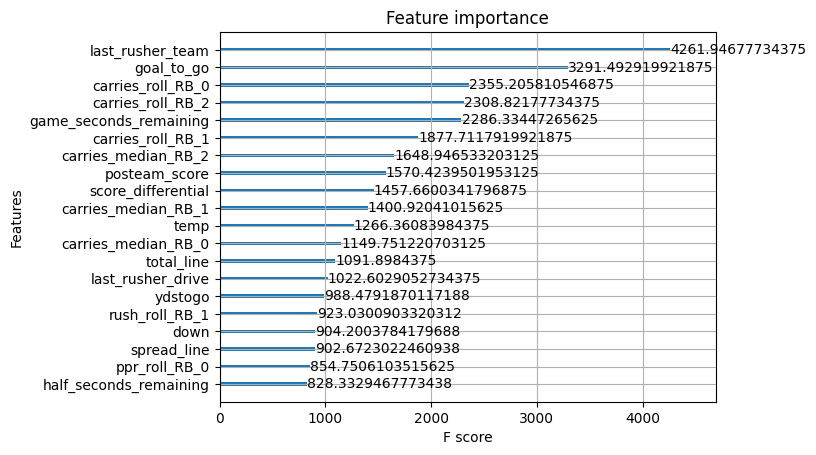

In [ ]:
xgb.plot_importance(choose_rusher_model, importance_type="cover", max_num_features=20)

In [ ]:
feature_config = {
    "choose_rusher_cols": choose_rusher_cols,
}
feature_config


{'choose_rusher_cols': ['yardline_100',
  'down',
  'goal_to_go',
  'ydstogo',
  'posteam_score',
  'score_differential',
  'quarter_seconds_remaining',
  'half_seconds_remaining',
  'game_seconds_remaining',
  'wind',
  'temp',
  'spread_line',
  'total_line',
  'ppr_roll_RB_0',
  'ppr_roll_RB_1',
  'ppr_roll_RB_2',
  'rush_roll_RB_0',
  'rush_roll_RB_1',
  'rush_roll_RB_2',
  'carries_roll_RB_1',
  'carries_roll_RB_2',
  'carries_roll_RB_0',
  'carries_median_RB_2',
  'carries_median_RB_1',
  'carries_median_RB_0',
  'last_rusher_drive',
  'last_rusher_team']}

In [ ]:
yaml_path = "models/feature_config.yaml"
with open(yaml_path, "r") as file:
    data = yaml.safe_load(file)  # Load the current content of the YAML file

# Update the data with the provided updates
data.update(feature_config)

with open(yaml_path, "w") as file:
    yaml.safe_dump(data, file)

In [ ]:
rushes.loc[(rushes.rusher=='K.Williams') &
           (rushes.game_id.str.contains('2024_10'))]['yards_gained']

87518    7.0
87519    1.0
87520    3.0
87521    3.0
87522    9.0
87523    2.0
87524    9.0
87525    3.0
87526    8.0
87527    5.0
87528    2.0
87529    4.0
87530    5.0
87531   -2.0
87532    0.0
87533    3.0
Name: yards_gained, dtype: float32

In [49]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(deep=True)

In [50]:
passes[["posteam", "season", "week"]]

,posteam,season,week
2,ARI,2010,1
4,ARI,2010,1
5,ARI,2010,1
7,ARI,2010,1
10,LA,2010,1
...,...,...,...
700832,WAS,2024,11
700833,WAS,2024,11
700834,WAS,2024,11
700835,WAS,2024,11


In [51]:
passes = passes.merge(
    team_receiver_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team_name", "season", "week"],
)
passes.sample(3)


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,receiving_yards_after_catch_roll_RB_1,receiving_yards_after_catch_roll_RB_0,receiving_first_downs_roll_RB_1,receiving_first_downs_roll_RB_0,target_share_roll_RB_1,target_share_roll_RB_0,air_yards_share_roll_RB_1,air_yards_share_roll_RB_0,fantasy_points_ppr_roll_RB_1,fantasy_points_ppr_roll_RB_0
210412,2499.0,2021_20_CIN_TEN,None,TEN,CIN,POST,20,CIN,away,TEN,...,3.486753,4.628081,0.127443,0.039713,0.020528,0.031837,-0.002557,0.000665,2.209489,1.517108
212363,2257.0,2022_02_LAC_KC,None,KC,LAC,REG,2,KC,home,LAC,...,26.870686,23.769242,1.476144,1.490985,0.078405,0.061686,-0.012100,-0.010745,9.151136,10.673503
233714,4879.0,2023_04_WAS_PHI,None,PHI,WAS,REG,4,PHI,home,WAS,...,21.943695,8.630119,0.524493,0.346312,0.103095,0.058430,-0.014166,0.016560,14.951345,5.674570


In [102]:
def get_passer_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate([
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
    ]):
        if row[col_name] == row["receiver_player_id"]:
            return num
    return None


In [103]:
passer_idx_to_pos = {
    idx: col_name.split('id_')[-1]
    for idx, col_name in enumerate([
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
    ])
}
passer_idx_to_pos

{0: 'WR_0',
 1: 'WR_1',
 2: 'WR_2',
 3: 'WR_3',
 4: 'WR_4',
 5: 'TE_0',
 6: 'TE_1',
 7: 'TE_2',
 8: 'RB_0',
 9: 'RB_1'}

In [105]:
passes['passer_idx'] = passes.apply(get_passer_number, axis=1)
passes[['posteam',
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
        'receiver_player_id',
        'passer_idx']]

,posteam,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1,receiver_player_id,passer_idx
0,ARI,00-0025529,00-0022921,00-0026221,00-0027349,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0023108,6.0
1,ARI,00-0025529,00-0022921,00-0026221,00-0027349,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0022921,1.0
2,ARI,00-0025529,00-0022921,00-0026221,00-0027349,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0026289,8.0
3,ARI,00-0025529,00-0022921,00-0026221,00-0027349,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0025529,0.0
4,ARI,00-0025529,00-0022921,00-0026221,00-0027349,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0026956,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258658,WAS,00-0039355,00-0035659,00-0035208,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699,00-0033955,NaN
258659,WAS,00-0039355,00-0035659,00-0035208,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699,00-0035208,2.0
258660,WAS,00-0039355,00-0035659,00-0035208,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699,00-0030061,5.0
258661,WAS,00-0039355,00-0035659,00-0035208,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699,00-0030061,5.0


In [106]:
len(passes.loc[passes.passer_idx.isna()])

25622

In [107]:
team_receiver_stats[["gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",]]

,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1
0,00-0025529,00-0022921,00-0026221,00-0027349,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
1,00-0025529,00-0022921,00-0027349,00-0026221,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
2,00-0025529,00-0022921,00-0027349,00-0027691,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0022288
3,00-0022921,00-0025529,00-0027349,00-0026221,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
4,00-0025529,00-0022921,00-0027349,00-0026221,00-0024645,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
...,...,...,...,...,...,...,...,...,...,...
8899,00-0035208,00-0035659,00-0039355,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699
8900,00-0035208,00-0035659,00-0039355,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699
8901,00-0039355,00-0035659,00-0035208,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699
8902,00-0039355,00-0035659,00-0035208,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699


In [109]:
choose_receiver_cols = game_context_cols + receiver_cols
choose_receiver_model = create_model(
    passes, x_cols=choose_receiver_cols, y_col="passer_idx"
)
joblib.dump(choose_receiver_cols, "models/choose_receiver.joblib")

Accuracy: 0.28
Confusion Matrix:


array([[4093, 2316,  684,  274,   82,  983,  226,   49,  309,  205],
       [2379, 4204,  742,  263,   89,  919,  223,   50,  302,  170],
       [1319, 1368, 1335,  161,   56,  575,  131,   30,  220,  135],
       [ 926,  927,  247,  466,   26,  399,   94,   38,  148,   76],
       [ 439,  387,  173,   66,  162,  163,   36,   12,   75,   43],
       [1745, 1724,  561,  209,   76, 1502,  101,   20,  264,  152],
       [ 875,  948,  299,  120,   33,  243,  345,   21,  124,   92],
       [ 345,  290,   97,   45,   23,  116,   56,   58,   49,   29],
       [1244, 1277,  395,  167,   66,  453,  129,   31,  526,   56],
       [ 826,  790,  272,  124,   34,  359,   97,   26,  103,  277]],
      dtype=int64)

['models/choose_receiver.joblib']

In [110]:
passer_idx_to_pos

{0: 'WR_0',
 1: 'WR_1',
 2: 'WR_2',
 3: 'WR_3',
 4: 'WR_4',
 5: 'TE_0',
 6: 'TE_1',
 7: 'TE_2',
 8: 'RB_0',
 9: 'RB_1'}

In [112]:
feature_config = {
    'passer_idx_to_pos': passer_idx_to_pos
}

In [113]:
yaml_path = "models/feature_config.yaml"
with open(yaml_path, "r") as file:
    data = yaml.safe_load(file)  # Load the current content of the YAML file

# Update the data with the provided updates
data.update(feature_config)

with open(yaml_path, "w") as file:
    yaml.safe_dump(data, file)